# Data Collection and Preprocessing
## Environmental Impact Analysis

This notebook implements CRISP-DM phases 1-3:
1. Business Understanding
2. Data Understanding
3. Data Preparation

In [1]:
# ============================================
# 🚀 AUTO-SETUP: Works in Colab & Local
# ============================================
import os
import sys

try:
    import google.colab
    IN_COLAB = True
    print("🔵 Running in Google Colab")
except:
    IN_COLAB = False
    print("🟢 Running locally")

if IN_COLAB:
    project_root = '/content/environmental_ml_project'
    if not os.path.exists(project_root):
        project_root = os.getcwd()
        if 'environmental_ml_project' not in project_root:
            for root, dirs, files in os.walk('/content'):
                if 'environmental_ml_project' in dirs:
                    project_root = os.path.join(root, 'environmental_ml_project')
                    break
    
    if os.path.exists(project_root):
        os.chdir(project_root)
    
    os.makedirs('results/figures', exist_ok=True)
    os.makedirs('results/metrics', exist_ok=True)
    os.makedirs('datasets', exist_ok=True)
    
    print("📦 Installing dependencies...")
    !pip install -q -r requirements.txt
    
    if 'src' not in sys.path:
        sys.path.insert(0, 'src')
    
    %matplotlib inline
else:
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.dirname(current_dir)
    else:
        project_root = current_dir
        if 'environmental_ml_project' in project_root:
            idx = project_root.find('environmental_ml_project')
            project_root = project_root[:idx + len('environmental_ml_project')]
    
    if os.path.exists(project_root) and os.path.basename(project_root) == 'environmental_ml_project':
        os.chdir(project_root)
    
    os.makedirs('results/figures', exist_ok=True)
    os.makedirs('results/metrics', exist_ok=True)
    os.makedirs('datasets', exist_ok=True)
    
    try:
        import pandas
        import numpy
        import matplotlib
        print("✅ Dependencies already installed")
    except ImportError:
        print("📦 Installing dependencies...")
        req_path = 'requirements.txt' if os.path.exists('requirements.txt') else '../requirements.txt'
        import subprocess
        
        if os.path.exists(req_path):
            with open(req_path, 'r') as f:
                packages = [line.strip() for line in f if line.strip() and not line.strip().startswith('#')]
            
            print(f"Installing {len(packages)} packages...")
            for pkg in packages:
                if pkg:
                    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '--no-cache-dir', pkg], check=False)
        else:
            print("⚠️  requirements.txt not found, installing core packages...")
            core_packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn']
            for pkg in core_packages:
                subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', pkg], check=False)
    
    src_path = 'src' if os.path.exists('src') else '../src'
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
    
    %matplotlib inline

print(f"✅ Setup complete! Working in: {os.getcwd()}")
print(f"✅ Python path includes: {[p for p in sys.path if 'src' in p]}")

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from data_generator import AirQualityDataGenerator, ClimateTextDataGenerator, create_integrated_dataset
from data_preprocessing import DataPreprocessor, TextPreprocessor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

🟢 Running locally
✅ Dependencies already installed
✅ Setup complete! Working in: /home/durga/environmental_ml_project
✅ Python path includes: ['src']
Libraries imported successfully!


## Business Understanding

### Research Questions:
1. **Student 1:** Can we predict Air Quality Index categories?
2. **Student 2:** Can we classify climate policy sentiment?
3. **Integrated:** What relationships exist between air quality and policy discourse?

## Generate Air Quality Dataset

In [2]:
print("Generating Air Quality Dataset...")
air_quality_generator = AirQualityDataGenerator(n_samples=15000, random_state=42)
air_quality_df = air_quality_generator.generate_dataset()
print(f"Shape: {air_quality_df.shape}")
air_quality_df.head()

Generating Air Quality Dataset...
Shape: (15000, 20)


,timestamp,country,city,station_type,temperature,humidity,wind_speed,precipitation,pm2.5,pm10,no2,co,o3,so2,aqi,aqi_category,hour,day_of_week,month,season
0,2020-01-01 00:00:00,Belgium,Bruges,Industrial,20.22,33.85,5.42,1.23,38.38,53.33,30.49,0.418,53.27,10.70,109.67,Unhealthy_for_Sensitive,0.0,2.0,1.0,1.0
1,2020-01-01 01:00:00,France,Toulouse,Rural,18.09,34.29,7.61,0.00,18.39,25.05,24.59,NaN,43.20,0.76,61.48,Moderate,1.0,2.0,1.0,1.0
2,2020-01-01 02:00:00,Italy,Turin,Rural,14.78,41.11,5.79,5.95,29.44,42.04,31.27,0.402,70.26,4.96,84.12,Moderate,2.0,2.0,1.0,1.0
3,2020-01-01 03:00:00,Italy,Milan,Urban_Traffic,12.21,48.23,5.23,0.00,48.77,85.61,43.88,0.666,41.48,0.25,171.23,Unhealthy,3.0,2.0,1.0,1.0
4,2020-01-01 04:00:00,France,Marseille,Industrial,19.80,40.86,2.92,0.00,32.03,36.87,24.11,0.554,41.81,11.43,91.52,Moderate,4.0,2.0,1.0,1.0


In [3]:
print("Dataset Information:")
air_quality_df.info()
print("\nStatistical Summary:")
air_quality_df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      14686 non-null  datetime64[ns]
 1   country        14684 non-null  object        
 2   city           14694 non-null  object        
 3   station_type   14680 non-null  object        
 4   temperature    14694 non-null  float64       
 5   humidity       14694 non-null  float64       
 6   wind_speed     14707 non-null  float64       
 7   precipitation  14700 non-null  float64       
 8   pm2.5          14681 non-null  float64       
 9   pm10           14669 non-null  float64       
 10  no2            14715 non-null  float64       
 11  co             14702 non-null  float64       
 12  o3             14706 non-null  float64       
 13  so2            14691 non-null  float64       
 14  aqi            14714 non-null  float64       
 15

,timestamp,temperature,humidity,wind_speed,precipitation,pm2.5,pm10,no2,co,o3,so2,aqi,hour,day_of_week,month,season
count,14686,14694.000000,14694.000000,14707.000000,14700.000000,14681.000000,14669.000000,14715.000000,14702.000000,14706.000000,14691.000000,14714.000000,14698.000000,14683.000000,14722.000000,14701.000000
mean,2020-11-08 17:04:11.504834304,11.349488,48.622154,15.188217,0.398129,25.344120,37.015985,33.294894,0.426189,46.276399,6.051214,93.263461,11.498299,2.996118,5.808178,2.395211
min,2020-01-01 00:00:00,-25.500000,20.000000,0.000000,0.000000,1.590000,0.000000,0.000000,0.000000,0.000000,0.000000,28.800000,0.000000,0.000000,1.000000,1.000000
25%,2020-06-05 09:15:00,1.260000,34.850000,9.640000,0.000000,20.680000,27.490000,26.190000,0.329000,32.990000,3.470000,76.930000,5.250000,1.000000,3.000000,2.000000
50%,2020-11-08 21:30:00,12.380000,47.760000,15.040000,0.000000,25.160000,36.730000,33.180000,0.426000,47.070000,5.720000,91.790000,11.000000,3.000000,6.000000,2.000000
75%,2021-04-13 19:45:00,21.140000,61.860000,20.250000,0.000000,29.850000,46.450000,40.195000,0.523000,59.870000,8.365000,107.400000,17.000000,5.000000,8.000000,3.000000
max,2021-09-16 23:00:00,39.900000,95.000000,43.800000,15.530000,60.610000,97.360000,72.640000,1.034000,100.260000,20.120000,194.720000,23.000000,6.000000,12.000000,4.000000
std,NaN,11.771010,16.986519,7.595901,1.200281,6.806577,13.972090,10.246596,0.142300,17.560988,3.538939,21.888017,6.917679,1.998412,3.199546,1.030020


In [4]:
print("Missing Values:")
missing = air_quality_df.isnull().sum()
print(missing[missing > 0])
print(f"\nTarget Distribution:")
print(air_quality_df['aqi_category'].value_counts())

Missing Values:
timestamp        314
country          316
city             306
station_type     320
temperature      306
humidity         306
wind_speed       293
precipitation    300
pm2.5            319
pm10             331
no2              285
co               298
o3               294
so2              309
aqi              286
aqi_category     289
hour             302
day_of_week      317
month            278
season           299
dtype: int64

Target Distribution:
aqi_category
Moderate                   9229
Unhealthy_for_Sensitive    5196
Unhealthy                   144
Good                        142
Name: count, dtype: int64


## Generate Climate Text Dataset

In [5]:
print("Generating Climate Text Dataset...")
text_generator = ClimateTextDataGenerator(n_samples=9500, random_state=42)
text_df = text_generator.generate_dataset()
print(f"Shape: {text_df.shape}")
text_df.head()

Generating Climate Text Dataset...
Shape: (9500, 8)


,document_id,publication_date,text,sentiment,source_type,urgency,impact_score,word_count
0,DOC_00001,2023-01-19,Controversy surrounds the proposed carbon capt...,Negative,Press_Release,High,2.58,41
1,DOC_00002,2021-11-16,Annual report on energy production trends indi...,Neutral,Government_Report,Medium,3.23,42
2,DOC_00003,2024-03-30,Conference on clean air act brings together po...,Neutral,News_Article,Medium,2.52,43
3,DOC_00004,2024-02-08,Community-led initiatives in Finland demonstra...,Positive,Policy_Document,Low,4.68,42
4,DOC_00005,2023-03-18,New regulations on transportation emissions ha...,Positive,Policy_Document,Low,3.91,44


In [6]:
print("Text Dataset Info:")
text_df.info()
print(f"\nAverage words: {text_df['word_count'].mean():.1f}")
print("\nSentiment Distribution:")
print(text_df['sentiment'].value_counts())

Text Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9500 entries, 0 to 9499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   document_id       9500 non-null   object        
 1   publication_date  9500 non-null   datetime64[ns]
 2   text              9500 non-null   object        
 3   sentiment         9500 non-null   object        
 4   source_type       9452 non-null   object        
 5   urgency           9453 non-null   object        
 6   impact_score      9500 non-null   float64       
 7   word_count        9500 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 593.9+ KB

Average words: 42.6

Sentiment Distribution:
sentiment
Negative    3325
Positive    3325
Neutral     2850
Name: count, dtype: int64


## EDA - Air Quality Visualizations

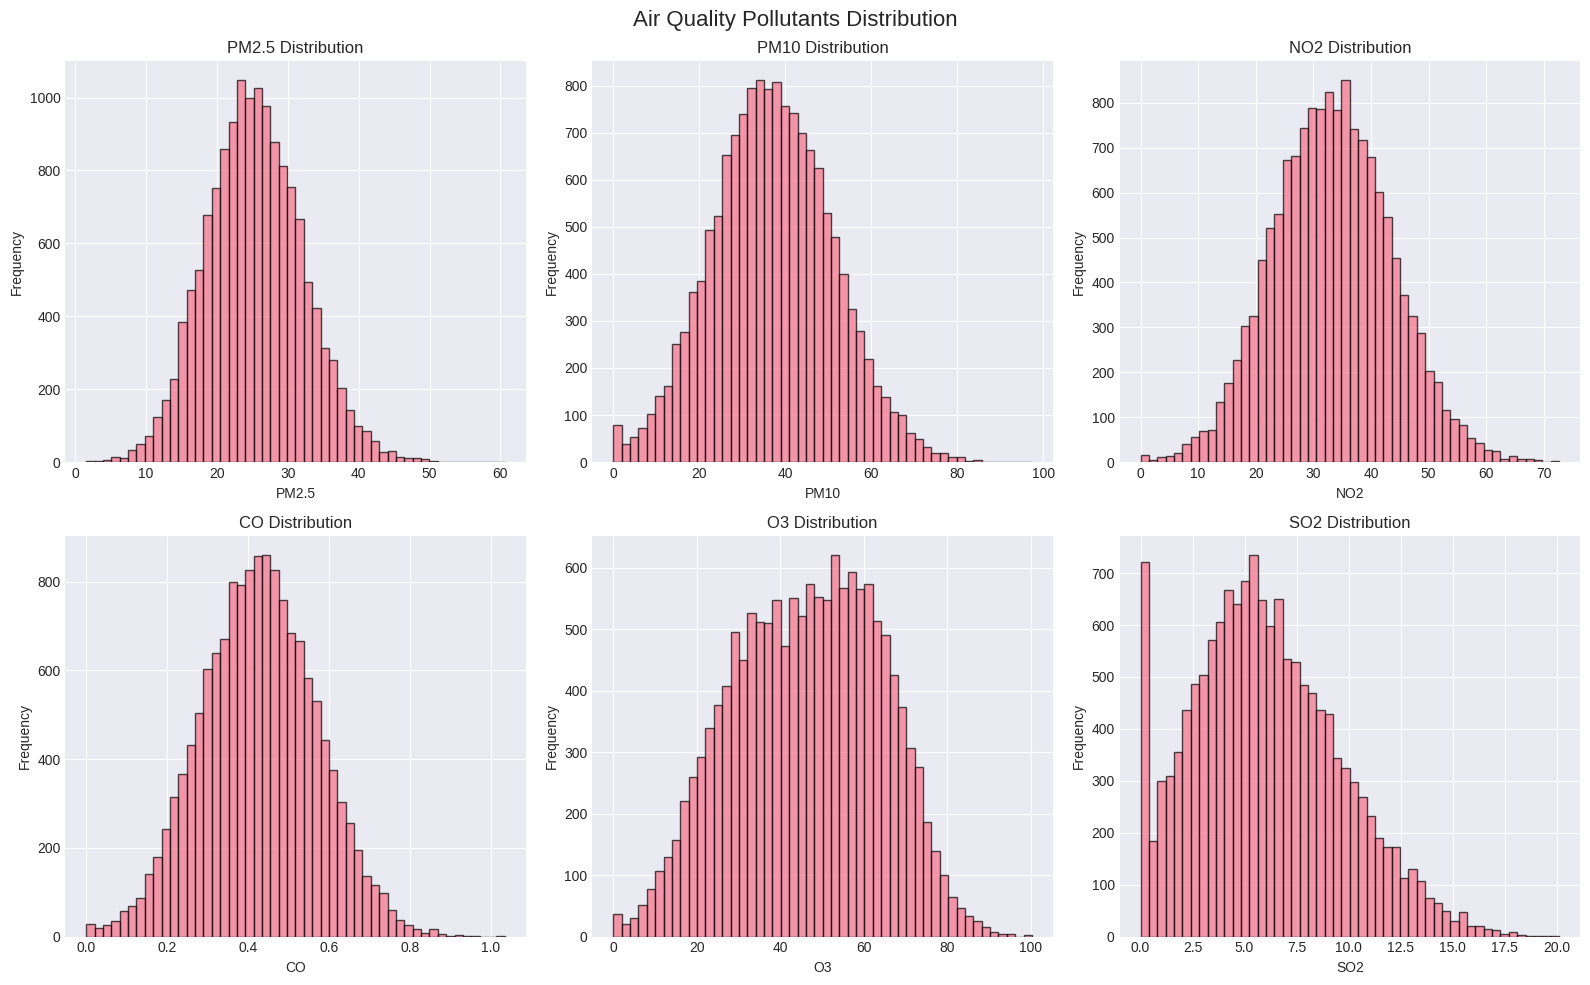

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Air Quality Pollutants Distribution', fontsize=16)
pollutants = ['pm2.5', 'pm10', 'no2', 'co', 'o3', 'so2']
for idx, pol in enumerate(pollutants):
    row, col = idx // 3, idx % 3
    axes[row, col].hist(air_quality_df[pol].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_title(f'{pol.upper()} Distribution')
    axes[row, col].set_xlabel(pol.upper())
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('results/figures/pollutants_dist.png', dpi=300)
plt.show()

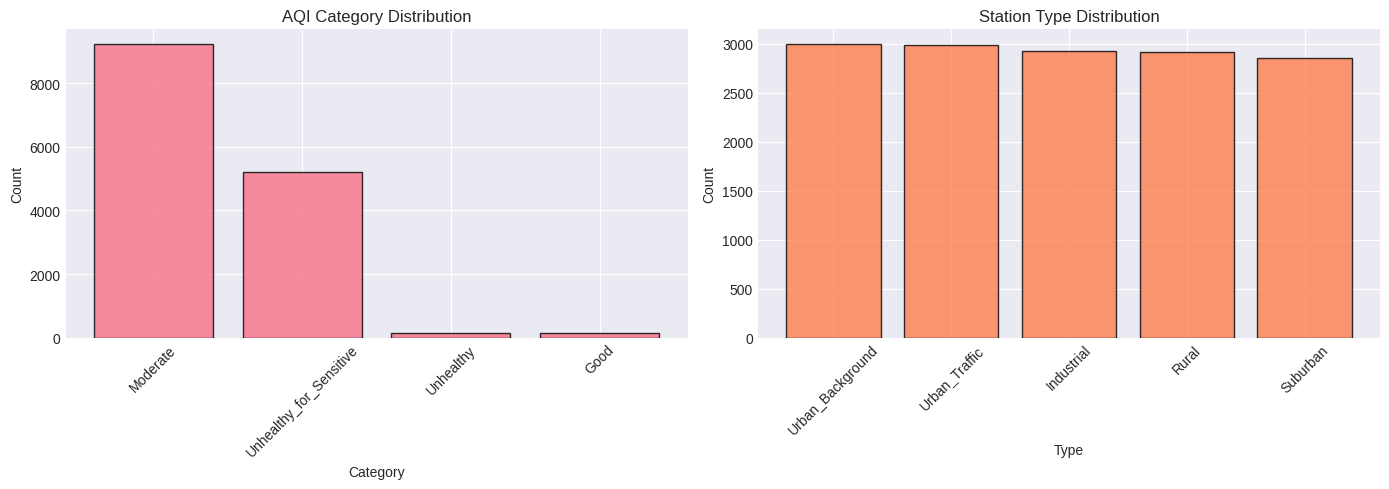

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
aqi_counts = air_quality_df['aqi_category'].value_counts()
axes[0].bar(aqi_counts.index, aqi_counts.values, edgecolor='black', alpha=0.8)
axes[0].set_title('AQI Category Distribution')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
station_counts = air_quality_df['station_type'].value_counts()
axes[1].bar(station_counts.index, station_counts.values, edgecolor='black', alpha=0.8, color='coral')
axes[1].set_title('Station Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('results/figures/categories.png', dpi=300)
plt.show()

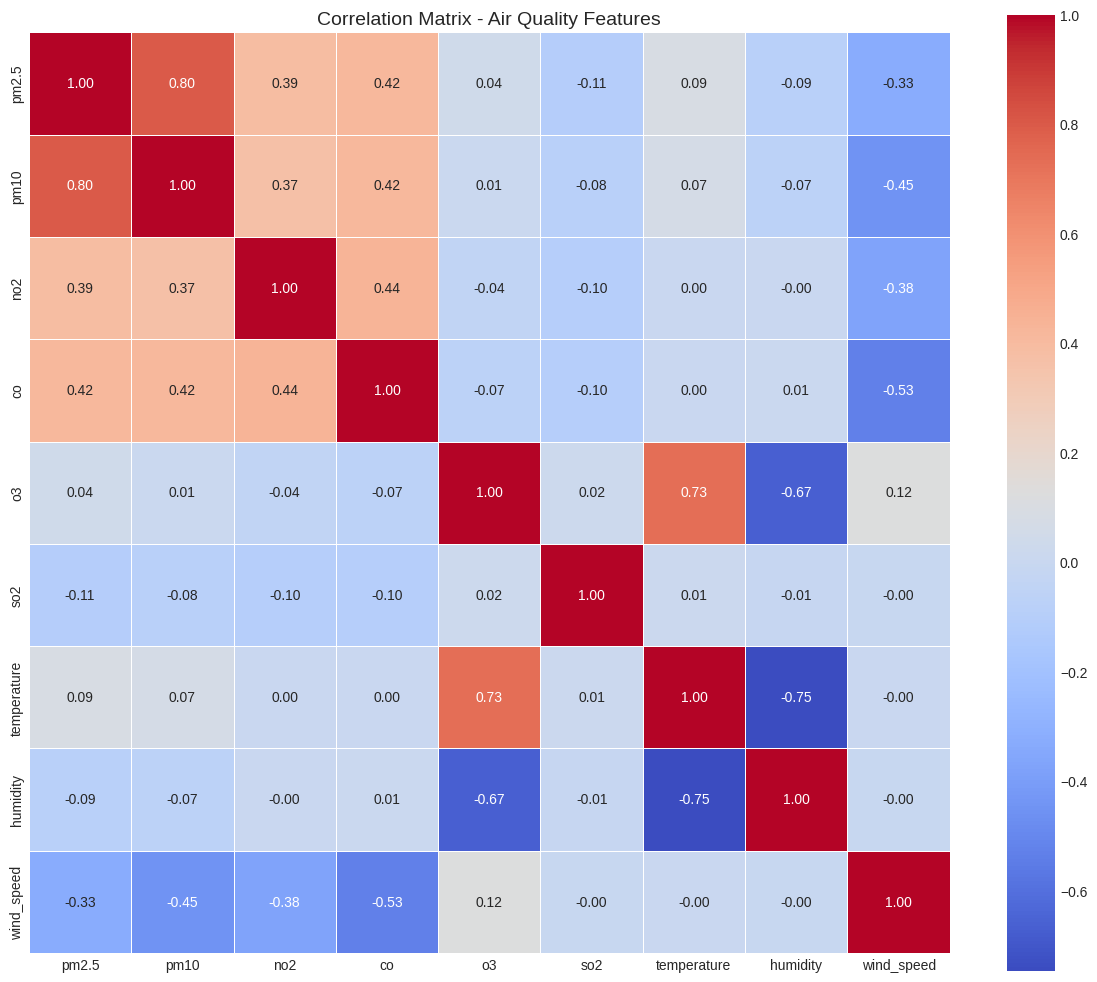

In [9]:
cols = ['pm2.5', 'pm10', 'no2', 'co', 'o3', 'so2', 'temperature', 'humidity', 'wind_speed']
corr = air_quality_df[cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix - Air Quality Features', fontsize=14)
plt.tight_layout()
plt.savefig('results/figures/correlation.png', dpi=300)
plt.show()

## EDA - Text Data Visualizations

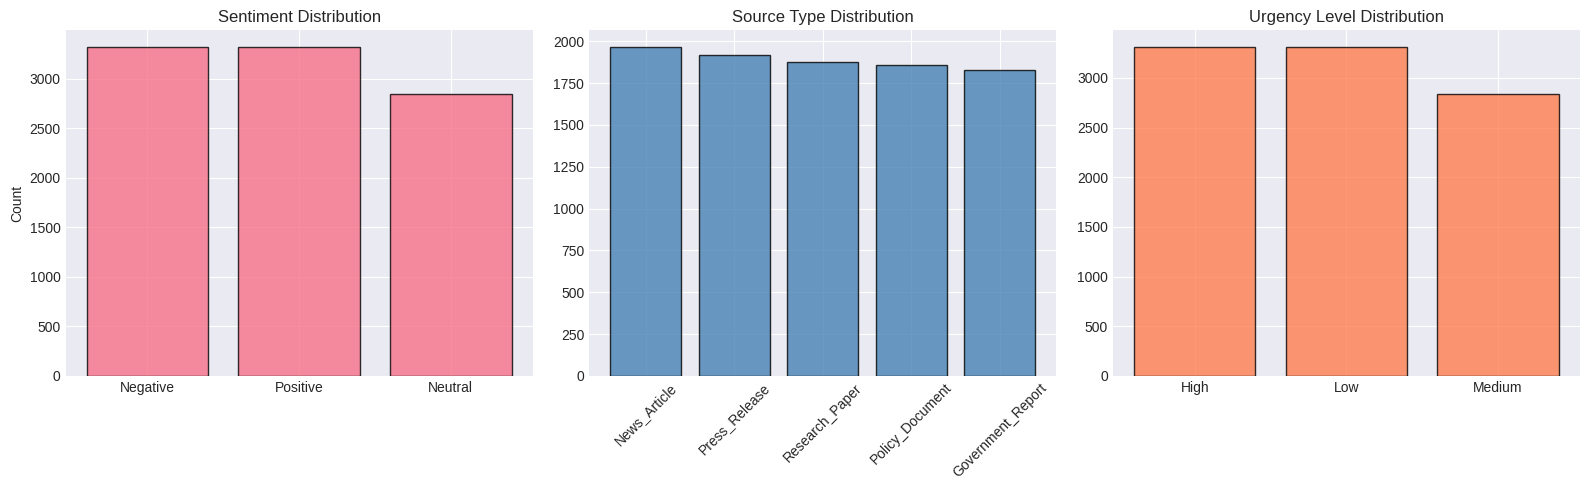

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sentiment_counts = text_df['sentiment'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, edgecolor='black', alpha=0.8)
axes[0].set_title('Sentiment Distribution')
axes[0].set_ylabel('Count')
source_counts = text_df['source_type'].value_counts()
axes[1].bar(source_counts.index, source_counts.values, edgecolor='black', alpha=0.8, color='steelblue')
axes[1].set_title('Source Type Distribution')
axes[1].tick_params(axis='x', rotation=45)
urgency_counts = text_df['urgency'].value_counts()
axes[2].bar(urgency_counts.index, urgency_counts.values, edgecolor='black', alpha=0.8, color='coral')
axes[2].set_title('Urgency Level Distribution')
plt.tight_layout()
plt.savefig('results/figures/text_dist.png', dpi=300)
plt.show()

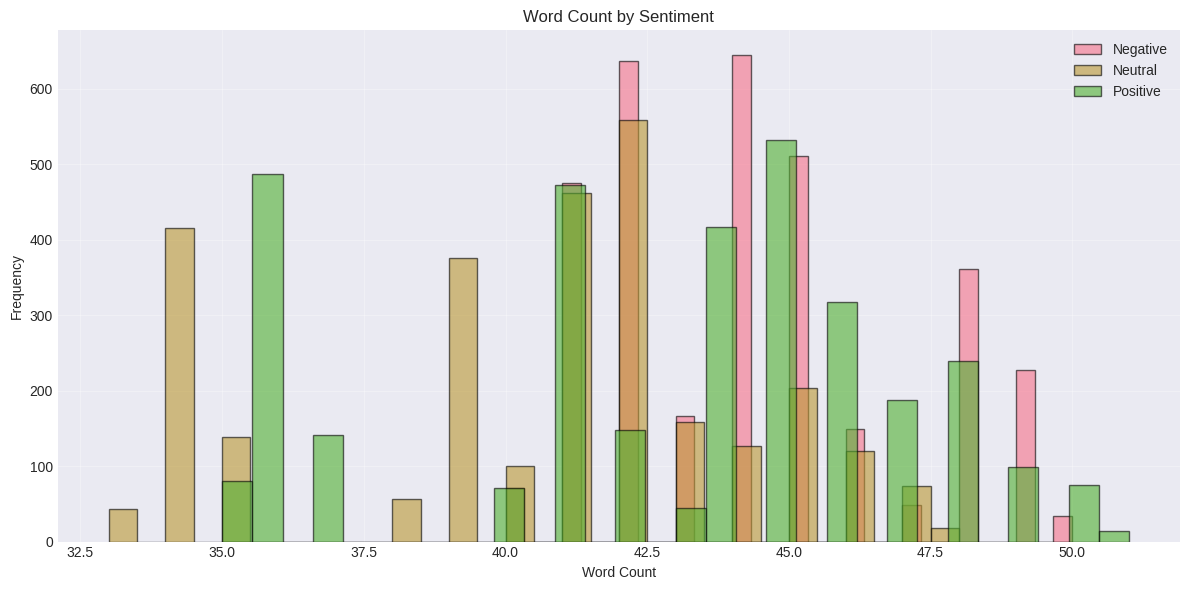

In [11]:
plt.figure(figsize=(12, 6))
for sentiment in text_df['sentiment'].unique():
    subset = text_df[text_df['sentiment'] == sentiment]
    plt.hist(subset['word_count'], bins=30, alpha=0.6, label=sentiment, edgecolor='black')
plt.title('Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/word_count.png', dpi=300)
plt.show()

## Data Preprocessing

In [12]:
print("Preprocessing Air Quality Data...")
air_preprocessor = DataPreprocessor()
air_quality_clean = air_quality_df.copy()
air_quality_clean = air_preprocessor.handle_missing_values(air_quality_clean, strategy='median')
print(f"Missing after imputation: {air_quality_clean.isnull().sum().sum()}")
numeric_pollutants = ['pm2.5', 'pm10', 'no2', 'co', 'o3', 'so2']
before = len(air_quality_clean)
air_quality_clean = air_preprocessor.remove_outliers(air_quality_clean, numeric_pollutants, method='iqr')
after = len(air_quality_clean)
print(f"Outliers removed: {before - after} ({(before-after)/before*100:.2f}%)")
print(f"Final shape: {air_quality_clean.shape}")

Preprocessing Air Quality Data...
Missing after imputation: 314
Outliers removed: 553 (3.69%)
Final shape: (14447, 20)


In [13]:
print("Creating derived features...")
air_quality_clean['pm_ratio'] = air_quality_clean['pm2.5'] / (air_quality_clean['pm10'] + 1e-10)
air_quality_clean['pollution_index'] = (air_quality_clean['pm2.5'] + air_quality_clean['pm10'] + air_quality_clean['no2']) / 3
air_quality_clean['is_weekend'] = air_quality_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
air_quality_clean['is_rush_hour'] = air_quality_clean['hour'].apply(lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0)
print("New features: pm_ratio, pollution_index, is_weekend, is_rush_hour")

Creating derived features...
New features: pm_ratio, pollution_index, is_weekend, is_rush_hour


In [14]:
print("Preprocessing Text Data...")
text_preprocessor = TextPreprocessor()
text_clean = text_df.copy()
text_clean = text_preprocessor.preprocess_text_column(text_clean, 'text', remove_stops=True)
text_clean = text_preprocessor.extract_text_features(text_clean, 'text')
print("Text features created: char_count, word_count, avg_word_length, sentence_count")
print(f"\nSample cleaned text:\n{text_clean['text_clean'].iloc[0][:200]}...")

Preprocessing Text Data...
Text features created: char_count, word_count, avg_word_length, sentence_count

Sample cleaned text:
controversy surrounds proposed carbon capture project environmental groups raise concerns ecological impact long term sustainability plan faced significant opposition local communities scientists ques...


## Create Integrated Dataset

In [15]:
print("Creating integrated dataset...")
integrated_df = create_integrated_dataset(air_quality_clean, text_clean)
print(f"Integrated shape: {integrated_df.shape}")
integrated_df.head()

Creating integrated dataset...
Integrated shape: (5699, 10)


,date,country,avg_pm25,avg_pm10,avg_no2,avg_aqi,aqi_category,sentiment_score,avg_impact_score,num_documents
0,2020-01-01,Austria,34.52,55.72,25.51,111.44,Unhealthy_for_Sensitive,0.0,2.84,19
1,2020-01-01,Belgium,35.30,50.16,31.84,110.88,Unhealthy_for_Sensitive,0.0,2.84,19
2,2020-01-01,France,25.21,30.96,24.35,76.50,Moderate,0.0,2.84,19
3,2020-01-01,Germany,28.43,42.14,36.86,98.36,Moderate,0.0,2.84,19
4,2020-01-01,Italy,25.09,33.22,29.72,80.92,Good,0.0,2.84,19


## Save Datasets

In [16]:
print("Saving datasets...")
air_quality_clean.to_csv('datasets/air_quality_data.csv', index=False)
print(f"✓ Air Quality saved: {air_quality_clean.shape}")
text_clean.to_csv('datasets/climate_news_text.csv', index=False)
print(f"✓ Climate Text saved: {text_clean.shape}")
integrated_df.to_csv('datasets/integrated_multimodal.csv', index=False)
print(f"✓ Integrated saved: {integrated_df.shape}")
print("\nDATA PREPARATION COMPLETE!")

Saving datasets...
✓ Air Quality saved: (14447, 24)
✓ Climate Text saved: (9500, 13)
✓ Integrated saved: (5699, 10)

DATA PREPARATION COMPLETE!


## Summary Report

In [17]:
print("="*60)
print("FINAL DATA SUMMARY REPORT")
print("="*60)
print(f"\n1. AIR QUALITY DATASET: {len(air_quality_clean):,} records, {air_quality_clean.shape[1]} features")
print(f"   Countries: {air_quality_clean['country'].nunique()}, Cities: {air_quality_clean['city'].nunique()}")
print(f"   Target Classes: {air_quality_clean['aqi_category'].nunique()}")
print(f"\n2. CLIMATE TEXT DATASET: {len(text_clean):,} records")
print(f"   Avg Word Count: {text_clean['word_count'].mean():.1f}")
print(f"   Sentiment Classes: {text_clean['sentiment'].nunique()}")
print(f"\n3. INTEGRATED DATASET: {len(integrated_df):,} records")
print("\nCRISP-DM Phases 1-3 Complete - Ready for Modeling")

FINAL DATA SUMMARY REPORT

1. AIR QUALITY DATASET: 14,447 records, 24 features
   Countries: 10, Cities: 40
   Target Classes: 4

2. CLIMATE TEXT DATASET: 9,500 records
   Avg Word Count: 42.6
   Sentiment Classes: 3

3. INTEGRATED DATASET: 5,699 records

CRISP-DM Phases 1-3 Complete - Ready for Modeling
